=== Iniciando análisis de predicción de precios de vehículos ===

=== Información del Dataset ===
Dimensiones: (301, 9)
Primeras 5 filas:
  Car_Name  Year  Selling_Price  Present_Price  Kms_Driven Fuel_Type  \
0     ritz  2014           3.35           5.59       27000    Petrol   
1      sx4  2013           4.75           9.54       43000    Diesel   
2     ciaz  2017           7.25           9.85        6900    Petrol   
3  wagon r  2011           2.85           4.15        5200    Petrol   
4    swift  2014           4.60           6.87       42450    Diesel   

  Seller_Type Transmission  Owner  
0      Dealer       Manual      0  
1      Dealer       Manual      0  
2      Dealer       Manual      0  
3      Dealer       Manual      0  
4      Dealer       Manual      0  
Estadísticas descriptivas:
              Year  Selling_Price  Present_Price     Kms_Driven       Owner
count   301.000000     301.000000     301.000000     301.000000  301.000000
mean   2013.627907       4.661296 

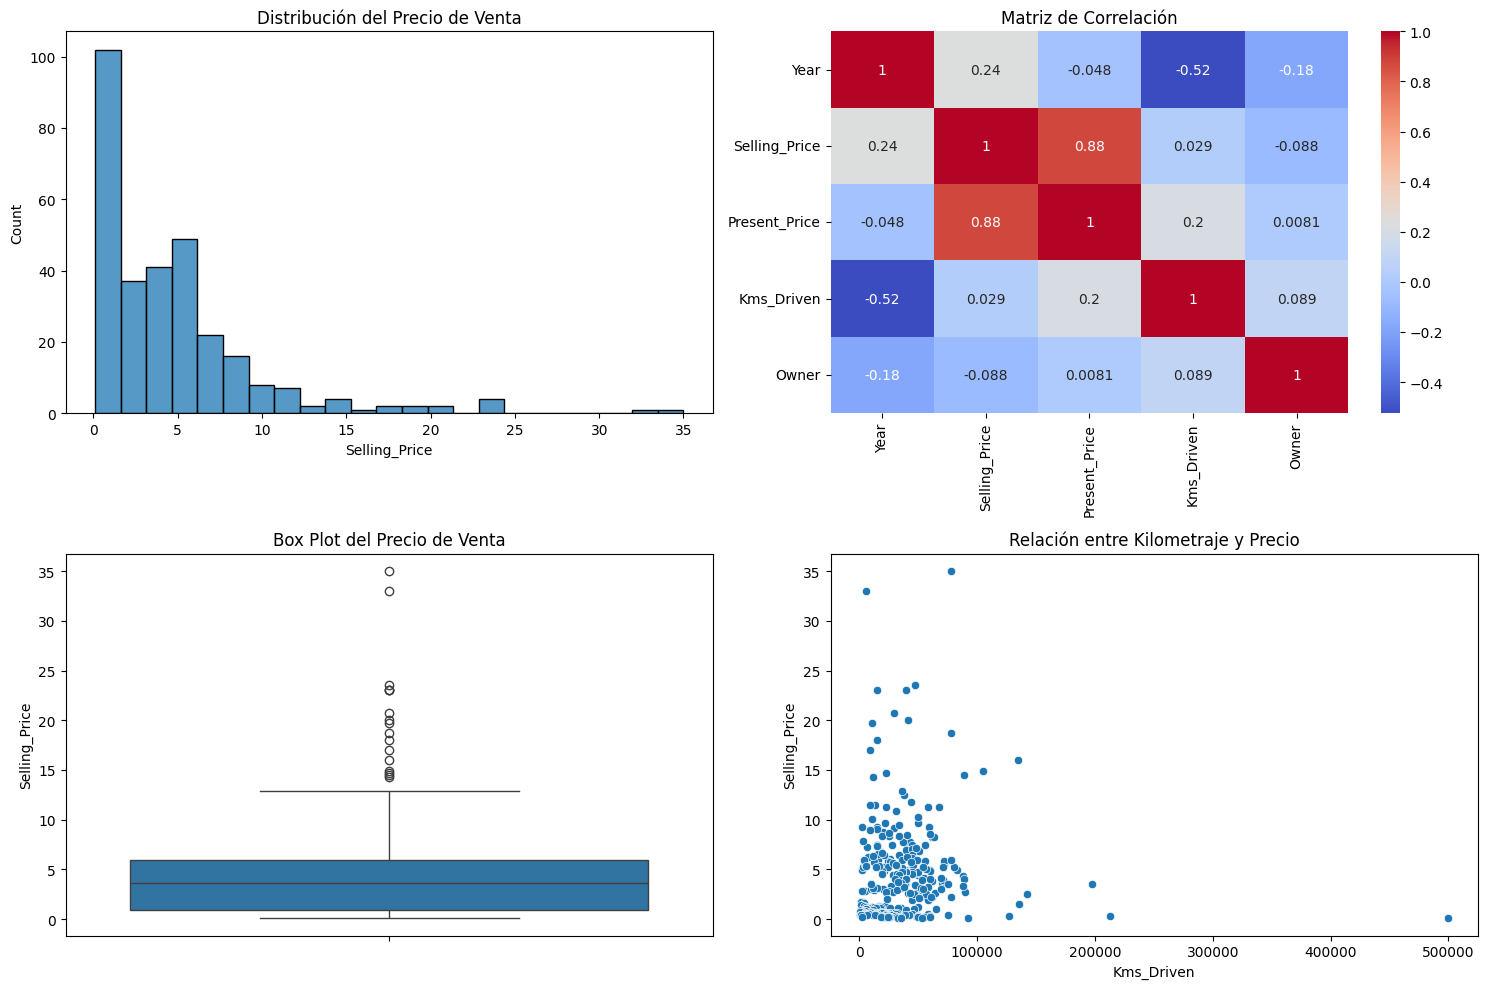

Características numéricas: Index(['Present_Price', 'Kms_Driven', 'Owner', 'vehicle_age'], dtype='object')
Características categóricas: Index(['Car_Name', 'Fuel_Type', 'Seller_Type', 'Transmission'], dtype='object')
Entrenando modelo...
=== Métricas de Evaluación ===
Train R2: 0.9182
Test R2: 0.8046
Train MSE: 2.0052
Test MSE: 5.0353
Train MAE: 1.0020
Test MAE: 1.3254


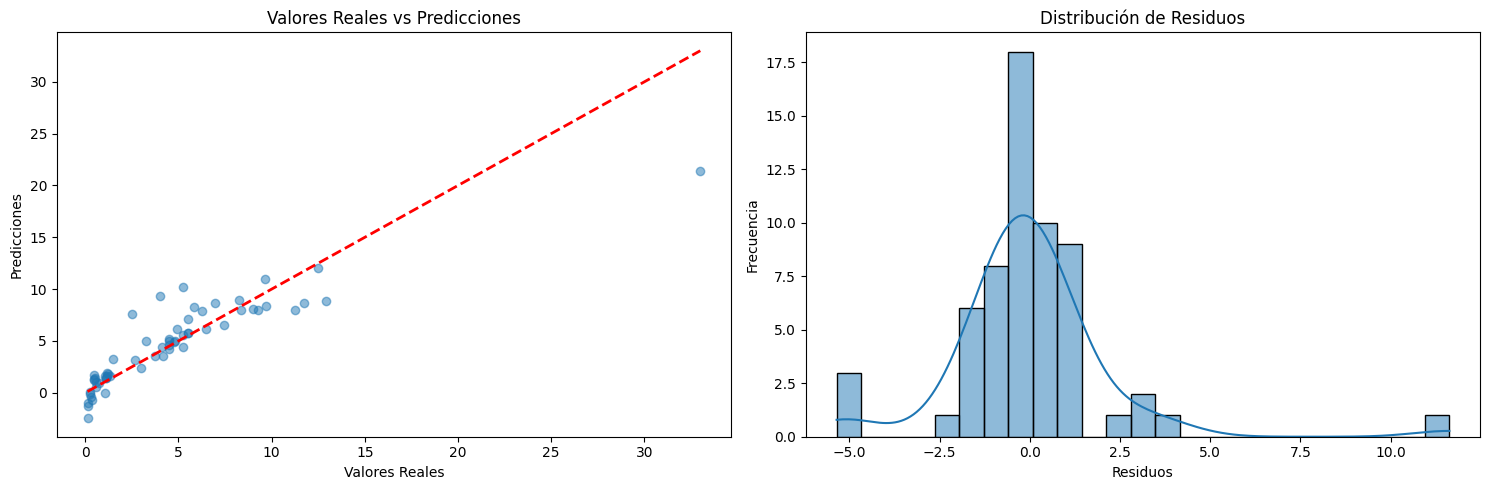

=== Interpretación de Resultados ===

    1. Calidad del modelo:
       - El R2 score indica qué tan bien el modelo explica la variabilidad en los datos
       - El MSE y MAE muestran el error promedio en las predicciones
       
    2. Análisis de residuos:
       - La distribución de residuos nos muestra si hay sesgos sistemáticos
       - Un modelo bien ajustado debería tener residuos normalmente distribuidos
       
    3. Predicciones vs Valores reales:
       - La diagonal roja representa predicciones perfectas
       - Los puntos dispersos muestran la precisión del modelo
    
None


In [84]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

# 1. Carga y Análisis Exploratorio de Datos
def load_and_explore_data(path: str):
    # Cargar datos
    df: pd.DataFrame = pd.read_csv(path)

    print("=== Información del Dataset ===")
    print(f"Dimensiones: {df.shape}")
    print("Primeras 5 filas:")
    print(df.head())
    print("Estadísticas descriptivas:")
    print(df.describe())
    print("Valores faltantes:")
    print(df.isnull().sum())

    # Visualizaciones
    plt.figure(figsize=(15, 10))

    # Distribución del precio (variable objetivo)
    plt.subplot(2, 2, 1)
    sns.histplot(df['Selling_Price'])
    plt.title('Distribución del Precio de Venta')

    # Correlación entre variables numéricas
    plt.subplot(2, 2, 2)
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    correlation_matrix = df[numeric_cols].corr()
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
    plt.title('Matriz de Correlación')

    # Box plot para detectar outliers en el precio
    plt.subplot(2, 2, 3)
    sns.boxplot(y=df['Selling_Price'])
    plt.title('Box Plot del Precio de Venta')

    # Scatter plot entre km_driven y selling_price
    plt.subplot(2, 2, 4)
    sns.scatterplot(data=df, x='Kms_Driven', y='Selling_Price')
    plt.title('Relación entre Kilometraje y Precio')

    plt.tight_layout()
    plt.show()

    return df

# 2. Preprocesamiento de datos
def preprocess_data(df: pd.DataFrame):
    # Eliminar duplicados
    df = df.drop_duplicates()

    # Convertir año a antigüedad del vehículo
    current_year = 2024
    df['vehicle_age'] = current_year - df['Year']
    df = df.drop('Year', axis=1)

    # Manejar categorías poco frecuentes
    for col in df.select_dtypes(include=['object']).columns:
        # Calcular frecuencias de categorías
        value_counts = df[col].value_counts()
        # Identificar categorías poco frecuentes (menos del 1% de los datos)
        rare_categories = value_counts[value_counts/len(df) < 0.01].index
        # Reemplazar categorías poco frecuentes con 'Other'
        df[col] = df[col].replace(rare_categories, 'Other')

    # Separar características y variable objetivo
    X = df.drop('Selling_Price', axis=1)
    y = df['Selling_Price']

    # Identificar columnas numéricas y categóricas
    numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
    categorical_features = X.select_dtypes(include=['object']).columns

    return X, y, numeric_features, categorical_features
# 3. y 4. Creación del pipeline con selección de características y división de datos
def create_pipeline_and_split_data(X, y, numeric_features, categorical_features):
    # Crear preprocessador
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numeric_features),
            ('cat', OneHotEncoder(
                drop='first',
                sparse_output=False,
                handle_unknown='ignore'  # Añadimos este parámetro
            ), categorical_features)
        ])

    # Crear pipeline
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('selector', SelectKBest(f_regression, k=10)),
        ('regressor', LinearRegression())
    ])

    # Dividir datos
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    return pipeline, X_train, X_test, y_train, y_test

# 5. Entrenamiento del modelo
def train_model(pipeline, X_train, y_train):
    pipeline.fit(X_train, y_train)
    return pipeline

# 6. Evaluación del modelo
def evaluate_model(pipeline, X_train, X_test, y_train, y_test):
    # Predicciones
    y_train_pred = pipeline.predict(X_train)
    y_test_pred = pipeline.predict(X_test)

    # Métricas de evaluación
    metrics = {
        'Train R2': r2_score(y_train, y_train_pred),
        'Test R2': r2_score(y_test, y_test_pred),
        'Train MSE': mean_squared_error(y_train, y_train_pred),
        'Test MSE': mean_squared_error(y_test, y_test_pred),
        'Train MAE': mean_absolute_error(y_train, y_train_pred),
        'Test MAE': mean_absolute_error(y_test, y_test_pred)
    }

    print("=== Métricas de Evaluación ===")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.4f}")

    return y_test_pred, metrics

# 7. Visualización de resultados
def plot_results(y_test, y_pred):
    plt.figure(figsize=(15, 5))

    # Gráfico de dispersión: Valores reales vs predichos
    plt.subplot(1, 2, 1)
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    plt.xlabel('Valores Reales')
    plt.ylabel('Predicciones')
    plt.title('Valores Reales vs Predicciones')

    # Gráfico de residuos
    residuals = y_test - y_pred
    plt.subplot(1, 2, 2)
    sns.histplot(residuals, kde=True)
    plt.xlabel('Residuos')
    plt.ylabel('Frecuencia')
    plt.title('Distribución de Residuos')

    plt.tight_layout()
    plt.show()

# 8. Función principal que ejecuta todo el proceso
def main(path):
    print("=== Iniciando análisis de predicción de precios de vehículos ===\n")

    # 1. Cargar y explorar datos
    df = load_and_explore_data(path)

    # 2. Preprocesar datos
    X, y, numeric_features, categorical_features = preprocess_data(df)
    print("Características numéricas:", numeric_features)
    print("Características categóricas:", categorical_features)

    # 3 y 4. Crear pipeline y dividir datos
    pipeline, X_train, X_test, y_train, y_test = create_pipeline_and_split_data(
        X, y, numeric_features, categorical_features
    )

    # 5. Entrenar modelo
    print("Entrenando modelo...")
    model = train_model(pipeline, X_train, y_train)

    # 6. Evaluar modelo
    y_pred, metrics = evaluate_model(model, X_train, X_test, y_train, y_test)

    # 7. Visualizar resultados
    plot_results(y_test, y_pred)

    # 8. Interpretación de resultados
    print("=== Interpretación de Resultados ===")
    print("""
    1. Calidad del modelo:
       - El R2 score indica qué tan bien el modelo explica la variabilidad en los datos
       - El MSE y MAE muestran el error promedio en las predicciones

    2. Análisis de residuos:
       - La distribución de residuos nos muestra si hay sesgos sistemáticos
       - Un modelo bien ajustado debería tener residuos normalmente distribuidos

    3. Predicciones vs Valores reales:
       - La diagonal roja representa predicciones perfectas
       - Los puntos dispersos muestran la precisión del modelo
    """)

if __name__ == "__main__":
  path: str = "/content/car data.csv"
  print(main(path))

=== Iniciando análisis de predicción de precios de vehículos ===

=== Información del Dataset ===
Dimensiones: (301, 9)
Primeras 5 filas:
  Car_Name  Year  Selling_Price  Present_Price  Kms_Driven Fuel_Type  \
0     ritz  2014           3.35           5.59       27000    Petrol   
1      sx4  2013           4.75           9.54       43000    Diesel   
2     ciaz  2017           7.25           9.85        6900    Petrol   
3  wagon r  2011           2.85           4.15        5200    Petrol   
4    swift  2014           4.60           6.87       42450    Diesel   

  Seller_Type Transmission  Owner  
0      Dealer       Manual      0  
1      Dealer       Manual      0  
2      Dealer       Manual      0  
3      Dealer       Manual      0  
4      Dealer       Manual      0  
Estadísticas descriptivas:
              Year  Selling_Price  Present_Price     Kms_Driven       Owner
count   301.000000     301.000000     301.000000     301.000000  301.000000
mean   2013.627907       4.661296 

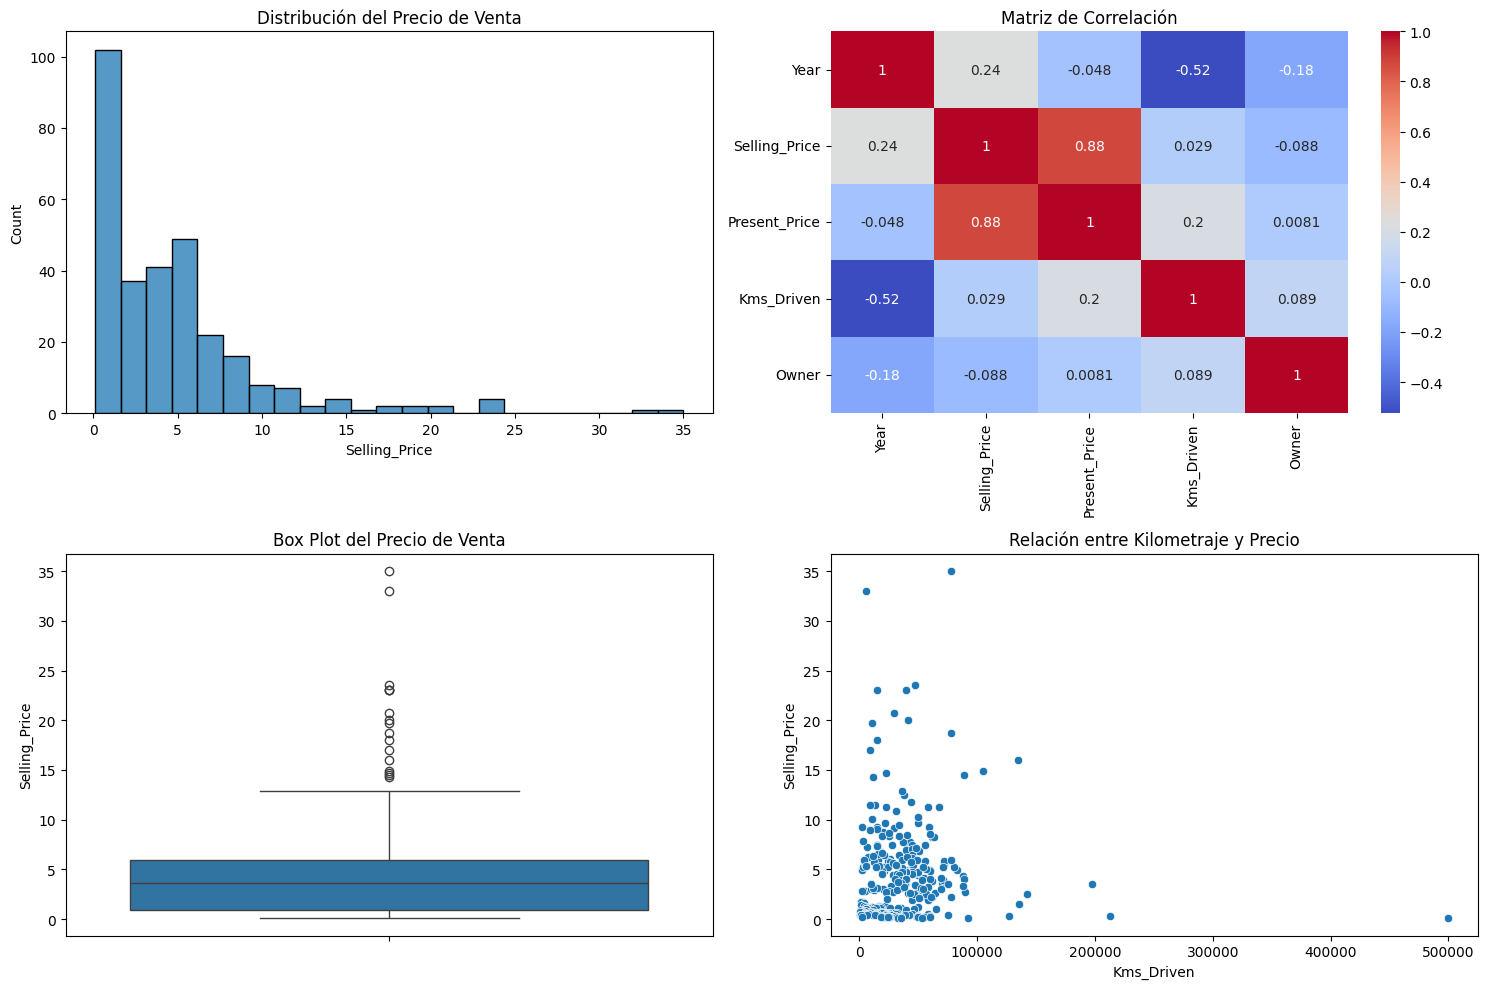

Características numéricas: Index(['Present_Price', 'Kms_Driven', 'Owner', 'vehicle_age'], dtype='object')
Características categóricas: Index(['Car_Name', 'Fuel_Type', 'Seller_Type', 'Transmission'], dtype='object')
Entrenando modelo...
=== Métricas de Evaluación ===
Train R2: 0.9182
Test R2: 0.8046
Train MSE: 2.0052
Test MSE: 5.0353
Train MAE: 1.0020
Test MAE: 1.3254


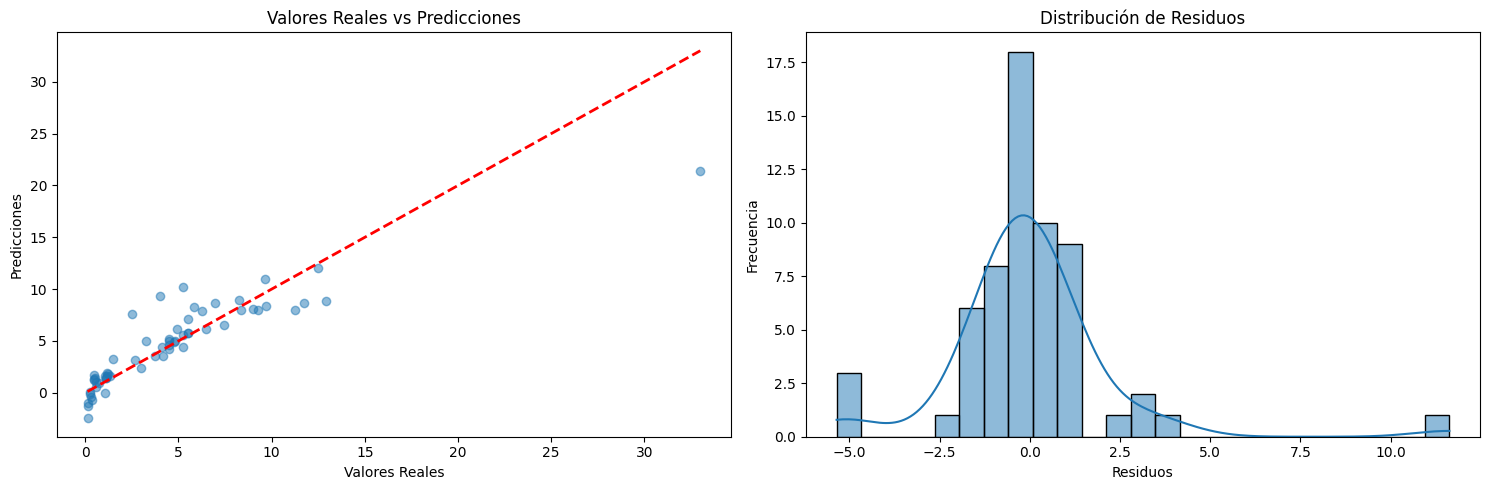

=== Interpretación de Resultados ===

    1. Calidad del modelo:
       - El R2 score indica qué tan bien el modelo explica la variabilidad en los datos
       - El MSE y MAE muestran el error promedio en las predicciones
       
    2. Análisis de residuos:
       - La distribución de residuos nos muestra si hay sesgos sistemáticos
       - Un modelo bien ajustado debería tener residuos normalmente distribuidos
       
    3. Predicciones vs Valores reales:
       - La diagonal roja representa predicciones perfectas
       - Los puntos dispersos muestran la precisión del modelo
    
None
